In [1]:
import numpy as np

In [125]:
from annoy import AnnoyIndex
import pickle
import os
import time
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from functools import wrapper

In [67]:
#local
track_vec = pickle.load(open('/Users/leo/Desktop/DSGA-1004/item_vec.pkl', 'rb'))
test_user_vec = pickle.load(open('/Users/leo/Desktop/DSGA-1004/user_vec.pkl', 'rb'))

In [56]:
#bian
track_vec = pickle.load(open('/Users/leo/Desktop/DSGA-1004/track_vec.pkl', 'rb'))
test_user_vec = pickle.load(open('/Users/leo/Desktop/DSGA-1004/val_user_vec.pkl', 'rb'))

In [141]:
f = len(track_vec[0])
t = AnnoyIndex(f, metric='dot')
for i in range(len(track_vec)):
    t.add_item(i, track_vec[i])

t.build(30)

True

In [72]:
len(test_user_vec)

10000

In [73]:
def find_nearest_exhaustive(data, queries, k):
    if len(data.shape) == 1:
        data = np.array([x for x in data])
    n_items = data.shape[0]
    n_feat = data.shape[1]
    n_queries = len(queries)
    
    def single_query(query):
        start = time.time()
        if type(query) is not np.ndarray:
            query = np.array(query)
        res = np.argsort(-data.dot(query))[:k]
        interval = time.time() - start
        return interval, res
    times = []
    results = []
    for i in tqdm(range(n_queries)):
        interval, res = single_query(queries[i])
        times.append(interval)
        results.append(res)
    mean_time = sum(times) / len(times)
    print('-' * 26)
    print('Exhaustive Brute-force Search\n')
    print('Mean Query Search: %.6f' % mean_time)
    
    return mean_time, results    

In [74]:
bf_mean_time, bf_results = find_nearest_exhaustive(track_vec, test_user_vec, 500)

--------------------------
Exhaustive Brute-force Search

Mean Query Search: 0.027584


In [86]:
# pickle.dump(bf_results, open('./bf_results', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
def wrap_with(obj, method, mapping):
    '''
    obj: the model that can respond to the query
    method: the name of the query method
    mapping: what input be mapped
    '''
    get_map = lambda x: [x[mapping[i]] for i in range(len(mapping))]
    def wrapped(*args, **kwrds):
        return obj.__getattribute__(method)(*get_map(args))
    return wrapped

<div style='background-color: #ffffb3;border-left: 5px solid #e6e600;padding: 0.5em;position:relative;'> 

<div style='position: absolute;top: 0px;left: 0;bottom: 0;right: 0;z-index: 0;overflow: hidden;font-size:60px; font-weight:bold; color: gray;opacity: 0.3;font-family: Arial, sans-serif'>⚠</div> <br>


Please wrap your model so that it can take input `(query, k)`


</div>

In [79]:
annoy10_wrapped = wrap_with(t, 'get_nns_by_vector', [0, 1])

In [135]:
def find_nearest_algo(data, queries, true_label, model_wrapped, k):
    if len(data.shape) == 1:
        data = np.array([x for x in data])
    n_items = data.shape[0]
    n_feat = data.shape[1]
    n_queries = len(queries)
    def single_query(query):
        start = time.time()
        res = model_wrapped(query, k)
        interval = time.time() - start
        return interval, res
    def get_recall(predict, truth):
        return len([x for x in predict if x in truth]) / len(truth)
    times = []
    recalls = []
    for i in tqdm(range(n_queries)):
        interval, res = single_query(queries[i])
        recall = get_recall(res, true_label[i])
        times.append(interval)
        recalls.append(recall)
    mean_time = sum(times) / len(times)
    mean_recall = sum(recalls) / len(recalls)
    print('-' * 26)
    print('Algorithm with k\' = %d\n' % k)
    print('Mean Query Search Time: %.6f' % mean_time)
    print('Mean Recall: %.6f' % mean_recall)
    
    return mean_time, mean_recall 

In [173]:
def make_plot(tree_list):
    for tree in tree_list:
        t.build(tree)
        num_query_list = []
        recall_list = []
        for k in range(50,501, 50):
            algo100_time, algo100_recall = find_nearest_algo(track_vec, test_user_vec, bf_results, annoy10_wrapped, k)
            num_query_list.append(1/algo100_time)
            recall_list.append(algo100_recall)
        plt.plot(recall_list, num_query_list, label = 'Annoy (num_tree = {})'.format(tree))
        plt.ylabel('Queries per second (1/s)')
        plt.xlabel('Recall')
        plt.title('Recall-Queries per second (1/s) tradeoff - up and to the right is better')
        plt.legend()
        plt.grid()

In [174]:
tree_list = [i for i in range(10,51,10)]

--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000329
Mean Recall: 0.083584


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000682
Mean Recall: 0.147661


--------------------------
Algorithm with k' = 150

Mean Query Search Time: 0.000897
Mean Recall: 0.186716


--------------------------
Algorithm with k' = 200

Mean Query Search Time: 0.001107
Mean Recall: 0.213950


--------------------------
Algorithm with k' = 250

Mean Query Search Time: 0.001461
Mean Recall: 0.236735


--------------------------
Algorithm with k' = 300

Mean Query Search Time: 0.001803
Mean Recall: 0.256108


--------------------------
Algorithm with k' = 350

Mean Query Search Time: 0.002029
Mean Recall: 0.275061


--------------------------
Algorithm with k' = 400

Mean Query Search Time: 0.002251
Mean Recall: 0.293059


--------------------------
Algorithm with k' = 450

Mean Query Search Time: 0.002680
Mean Recall: 0.309001


--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.003100
Mean Recall: 0.325238


--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000347
Mean Recall: 0.083584


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000703
Mean Recall: 0.147661


--------------------------
Algorithm with k' = 150

Mean Query Search Time: 0.000891
Mean Recall: 0.186716


--------------------------
Algorithm with k' = 200

Mean Query Search Time: 0.001257
Mean Recall: 0.213950


--------------------------
Algorithm with k' = 250

Mean Query Search Time: 0.001660
Mean Recall: 0.236735


--------------------------
Algorithm with k' = 300

Mean Query Search Time: 0.001908
Mean Recall: 0.256108


--------------------------
Algorithm with k' = 350

Mean Query Search Time: 0.002297
Mean Recall: 0.275061


--------------------------
Algorithm with k' = 400

Mean Query Search Time: 0.002488
Mean Recall: 0.293059


--------------------------
Algorithm with k' = 450

Mean Query Search Time: 0.002726
Mean Recall: 0.309001


--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.003110
Mean Recall: 0.325238


--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000304
Mean Recall: 0.083584


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000583
Mean Recall: 0.147661


--------------------------
Algorithm with k' = 150

Mean Query Search Time: 0.001015
Mean Recall: 0.186716


--------------------------
Algorithm with k' = 200

Mean Query Search Time: 0.001236
Mean Recall: 0.213950


--------------------------
Algorithm with k' = 250

Mean Query Search Time: 0.001391
Mean Recall: 0.236735


--------------------------
Algorithm with k' = 300

Mean Query Search Time: 0.001892
Mean Recall: 0.256108


--------------------------
Algorithm with k' = 350

Mean Query Search Time: 0.002018
Mean Recall: 0.275061


--------------------------
Algorithm with k' = 400

Mean Query Search Time: 0.002289
Mean Recall: 0.293059


--------------------------
Algorithm with k' = 450

Mean Query Search Time: 0.002573
Mean Recall: 0.309001


--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.003210
Mean Recall: 0.325238


--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000335
Mean Recall: 0.083584


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000668
Mean Recall: 0.147661


--------------------------
Algorithm with k' = 150

Mean Query Search Time: 0.001051
Mean Recall: 0.186716


--------------------------
Algorithm with k' = 200

Mean Query Search Time: 0.001398
Mean Recall: 0.213950


--------------------------
Algorithm with k' = 250

Mean Query Search Time: 0.001495
Mean Recall: 0.236735


--------------------------
Algorithm with k' = 300

Mean Query Search Time: 0.001797
Mean Recall: 0.256108


--------------------------
Algorithm with k' = 350

Mean Query Search Time: 0.002194
Mean Recall: 0.275061


--------------------------
Algorithm with k' = 400

Mean Query Search Time: 0.002489
Mean Recall: 0.293059


--------------------------
Algorithm with k' = 450

Mean Query Search Time: 0.002792
Mean Recall: 0.309001


--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.002890
Mean Recall: 0.325238


--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000289
Mean Recall: 0.083584


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000568
Mean Recall: 0.147661


--------------------------
Algorithm with k' = 150

Mean Query Search Time: 0.000830
Mean Recall: 0.186716


--------------------------
Algorithm with k' = 200

Mean Query Search Time: 0.001144
Mean Recall: 0.213950


--------------------------
Algorithm with k' = 250

Mean Query Search Time: 0.001410
Mean Recall: 0.236735


--------------------------
Algorithm with k' = 300

Mean Query Search Time: 0.001705
Mean Recall: 0.256108


--------------------------
Algorithm with k' = 350

Mean Query Search Time: 0.002033
Mean Recall: 0.275061


--------------------------
Algorithm with k' = 400

Mean Query Search Time: 0.002425
Mean Recall: 0.293059


--------------------------
Algorithm with k' = 450

Mean Query Search Time: 0.003003
Mean Recall: 0.309001


--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.003030
Mean Recall: 0.325238


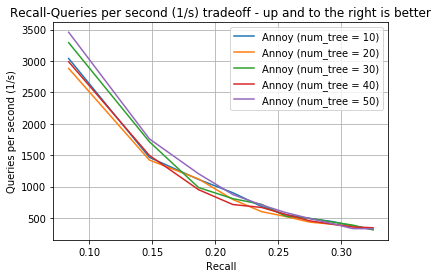

In [175]:
make_plot(tree_list)

In [81]:
algo100_time, algo100_recall = find_nearest_algo(track_vec, test_user_vec, bf_results, annoy10_wrapped, 500)

--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.003123
Mean Recall: 0.325238


In [183]:
algo_list = ['annoy', 'x']

--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000319
Mean Recall: 0.083584


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000632
Mean Recall: 0.147661
start nmslib


--------------------------
Algorithm with k' = 50

Mean Query Search Time: 0.000029
Mean Recall: 0.005164


--------------------------
Algorithm with k' = 100

Mean Query Search Time: 0.000041
Mean Recall: 0.011268


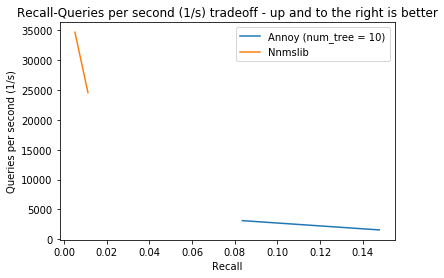

In [188]:
for algo in algo_list:
    if algo == 'annoy':
        f = len(track_vec[0])
        t = AnnoyIndex(f, metric='angular')
        for i in range(len(track_vec)):
            t.add_item(i, track_vec[i])
        t.build(10)
        num_query_list = []
        recall_list = []
        for k in range(50,101, 50):
            algo100_time, algo100_recall = find_nearest_algo(track_vec, test_user_vec, bf_results, annoy10_wrapped, k)
            num_query_list.append(1/algo100_time)
            recall_list.append(algo100_recall)
        plt.plot(recall_list, num_query_list, label = 'Annoy (num_tree = {})'.format(10))
        plt.ylabel('Queries per second (1/s)')
        plt.xlabel('Recall')
        plt.title('Recall-Queries per second (1/s) tradeoff - up and to the right is better')
        plt.legend()
        plt.grid()
    else:
        index = nmslib.init(method='hnsw', space='cosinesimil')
        index.addDataPointBatch(track_vec)
        index.createIndex({'post': 2}, print_progress=True)
        num_query_list = []
        recall_list = []
        for k in range(50,101, 50):
            algo100_time, algo100_recall = find_nearest_algo_nmslib(track_vec, test_user_vec, bf_results,k)
            num_query_list.append(1/algo100_time)
            recall_list.append(algo100_recall)
        plt.plot(recall_list, num_query_list, label = 'Nnmslib')
        plt.ylabel('Queries per second (1/s)')
        plt.xlabel('Recall')
        plt.title('Recall-Queries per second (1/s) tradeoff - up and to the right is better')
        plt.legend()
        plt.grid()

    


## nmslib

In [85]:
import nmslib

In [86]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(track_vec)
index.createIndex({'post': 2}, print_progress=True)
# pred_label = index.knnQueryBatch(test_user_vec, k=500, num_threads=4)

In [111]:
def find_nearest_algo_nmslib(data, queries, true_label, k):
    if len(data.shape) == 1:
        data = np.array([x for x in data])
    n_items = data.shape[0]
    n_feat = data.shape[1]
    n_queries = len(queries)
    def single_query(query):
        start = time.time()
        res, _ = index.knnQuery(query, k=k)
        interval = time.time() - start
        return interval, res
    def get_recall(predict, truth):
        return len([x for x in predict if x in truth]) / len(truth)
    times = []
    recalls = []
    for i in tqdm(range(n_queries)):
        interval, res = single_query(queries[i])
        recall = get_recall(res, true_label[i])
        times.append(interval)
        recalls.append(recall)
    mean_time = sum(times) / len(times)
    mean_recall = sum(recalls) / len(recalls)
    print('-' * 26)
    print('Algorithm with k\' = %d\n' % k)
    print('Mean Query Search Time: %.6f' % mean_time)
    print('Mean Recall: %.6f' % mean_recall)
    
    return mean_time, mean_recall 

In [114]:
algo100_time, algo100_recall = find_nearest_algo_nmslib(track_vec, test_user_vec, bf_results, 500)

--------------------------
Algorithm with k' = 500

Mean Query Search Time: 0.000060
Mean Recall: 0.019397
